# Comparing glider datasets

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import numpy as np
import cartopy
from erddapy import ERDDAP
import utils
import pytz
import argopy
from pathlib import Path
plt.rcParams.update({'font.size': 14})

# Get calibration ctd casts

Starting in April 2023, we take reference CTD casts when deploying and recovering gliders. These can be used to check for sensor drift

In [2]:
e = ERDDAP(
    server="https://erddap.observations.voiceoftheocean.org/erddap",
    protocol="tabledap",
)

# Fetch dataset list
e.response = "csv"
e.dataset_id = "allDatasets"
df_datasets = e.to_pandas(parse_dates=['minTime (UTC)', 'maxTime (UTC)'])

# drop the allDatasets row and make the datasetID the index for easier reading
df_datasets.set_index("datasetID", inplace=True)
df_datasets.drop("allDatasets", inplace=True)

df_datasets = df_datasets[df_datasets.index.str[:3] == "nrt"]

Download the glider datasets

In [3]:
e.dataset_id = "ctd_deployment"
df_ctd = e.to_xarray().drop_dims("timeseries").to_pandas()
#df_ctd = e.to_pandas()
df_ctd.index = df_ctd["time"]
df_ctd = df_ctd.sort_index()

In [4]:
ctd_casts = df_ctd.groupby("cast_no").first()

df_relevant = df_datasets
mintime = ctd_casts.time.min().replace(tzinfo=pytz.utc) - datetime.timedelta(days=1)
maxtime = ctd_casts.time.max().replace(tzinfo=pytz.utc) + datetime.timedelta(days=1)

df_relevant = df_relevant[df_relevant["minTime (UTC)"] > mintime ]
df_relevant = df_relevant[df_relevant["maxTime (UTC)"] < maxtime ]
df_relevant["longitude"] = (df_relevant["minLongitude (degrees_east)"] + df_relevant["maxLongitude (degrees_east)"]) / 2
df_relevant["latitude"] = (df_relevant["minLatitude (degrees_north)"] + df_relevant["maxLatitude (degrees_north)"]) / 2

df_relevant = df_relevant[['longitude',
                           'latitude',
 'minAltitude (m)',
 'maxAltitude (m)',
 'minTime (UTC)',
 'maxTime (UTC)',
]]
df_relevant = df_relevant.sort_values('minTime (UTC)')

In [5]:
nrt_dict = utils.download_glider_dataset(df_relevant.index[:3])

  0%|          | 0/3 [00:00<?, ?it/s]

/home/callum/mambaforge/envs/goosdemo/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


/home/callum/mambaforge/envs/goosdemo/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


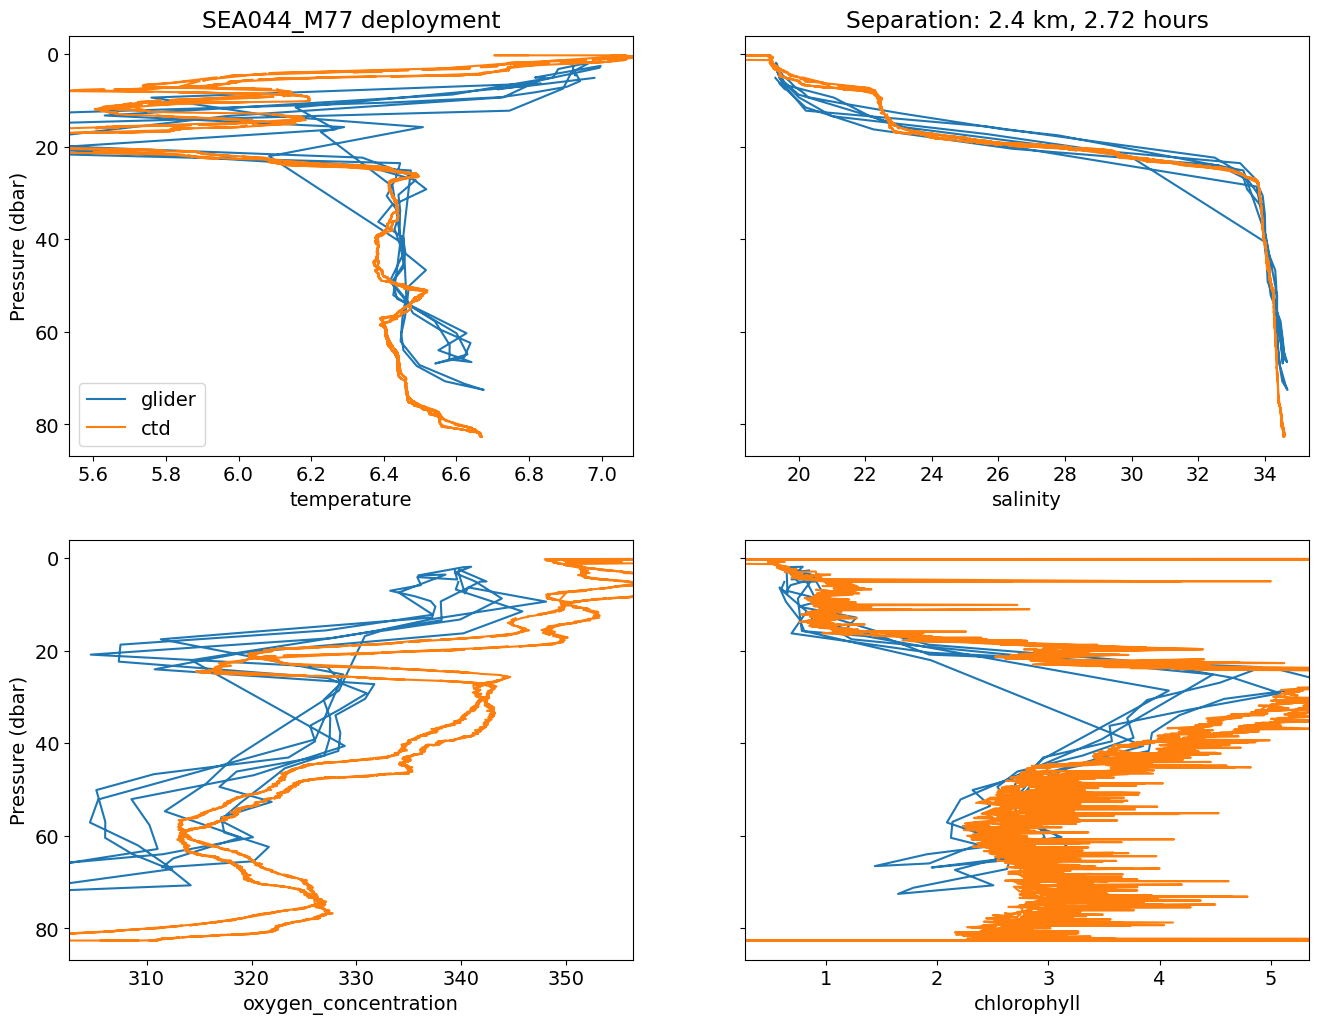

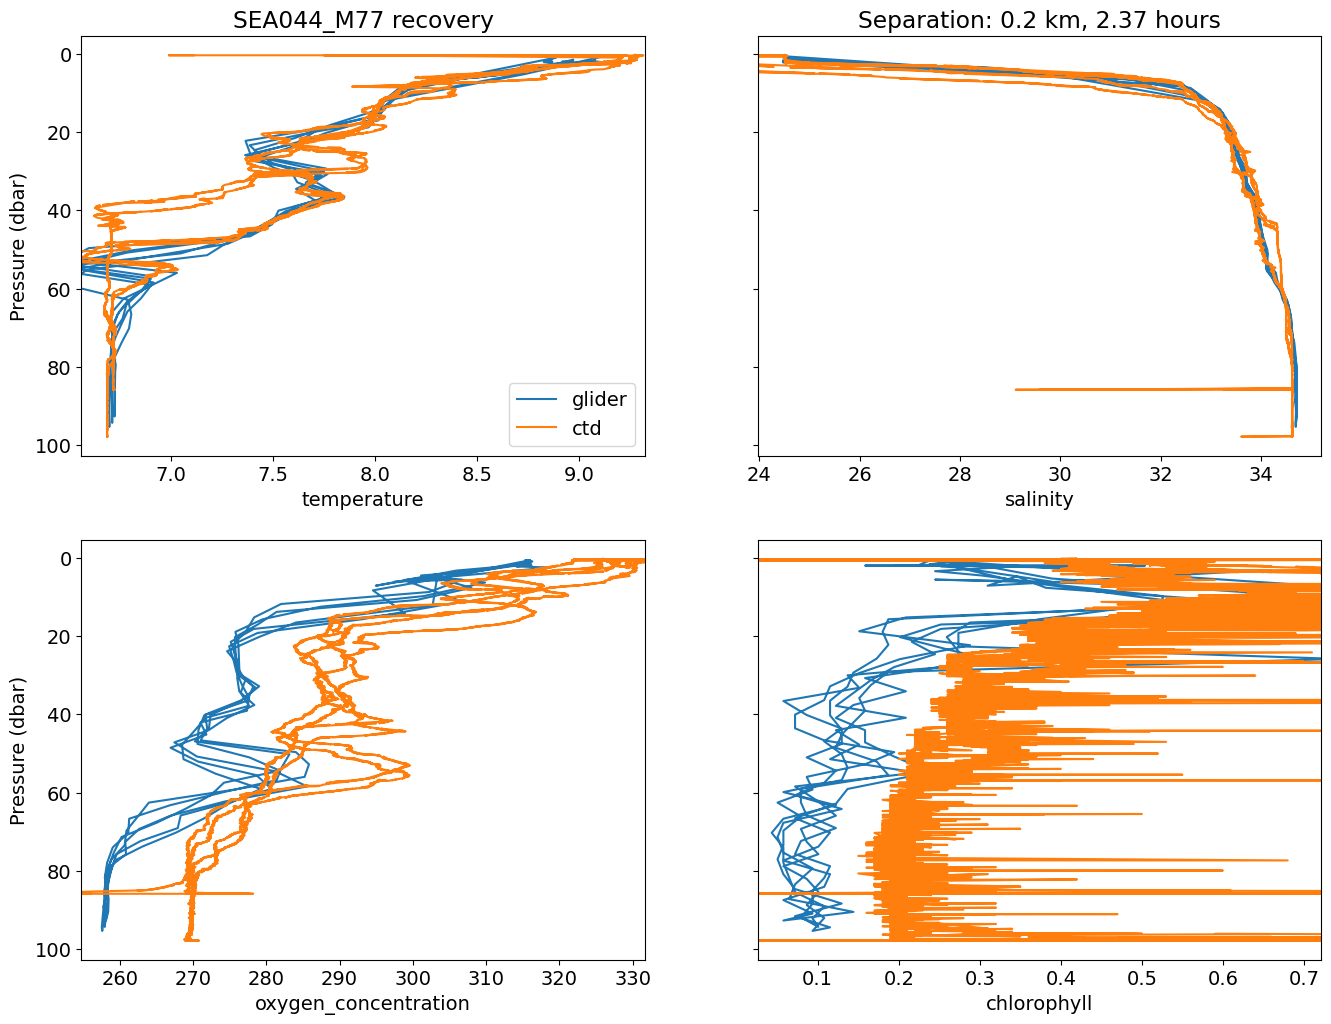

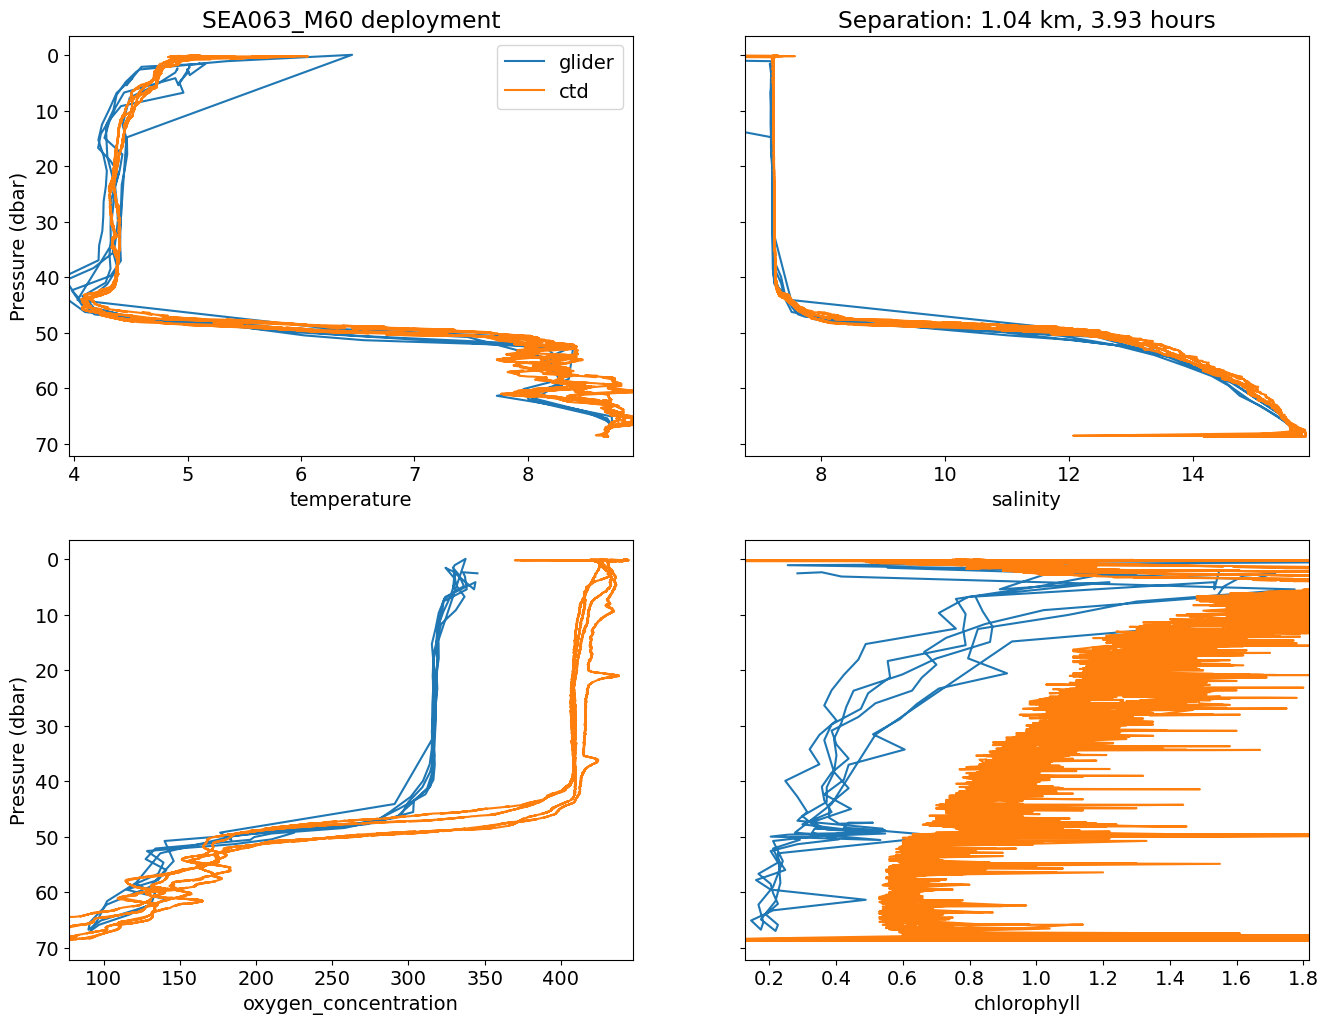

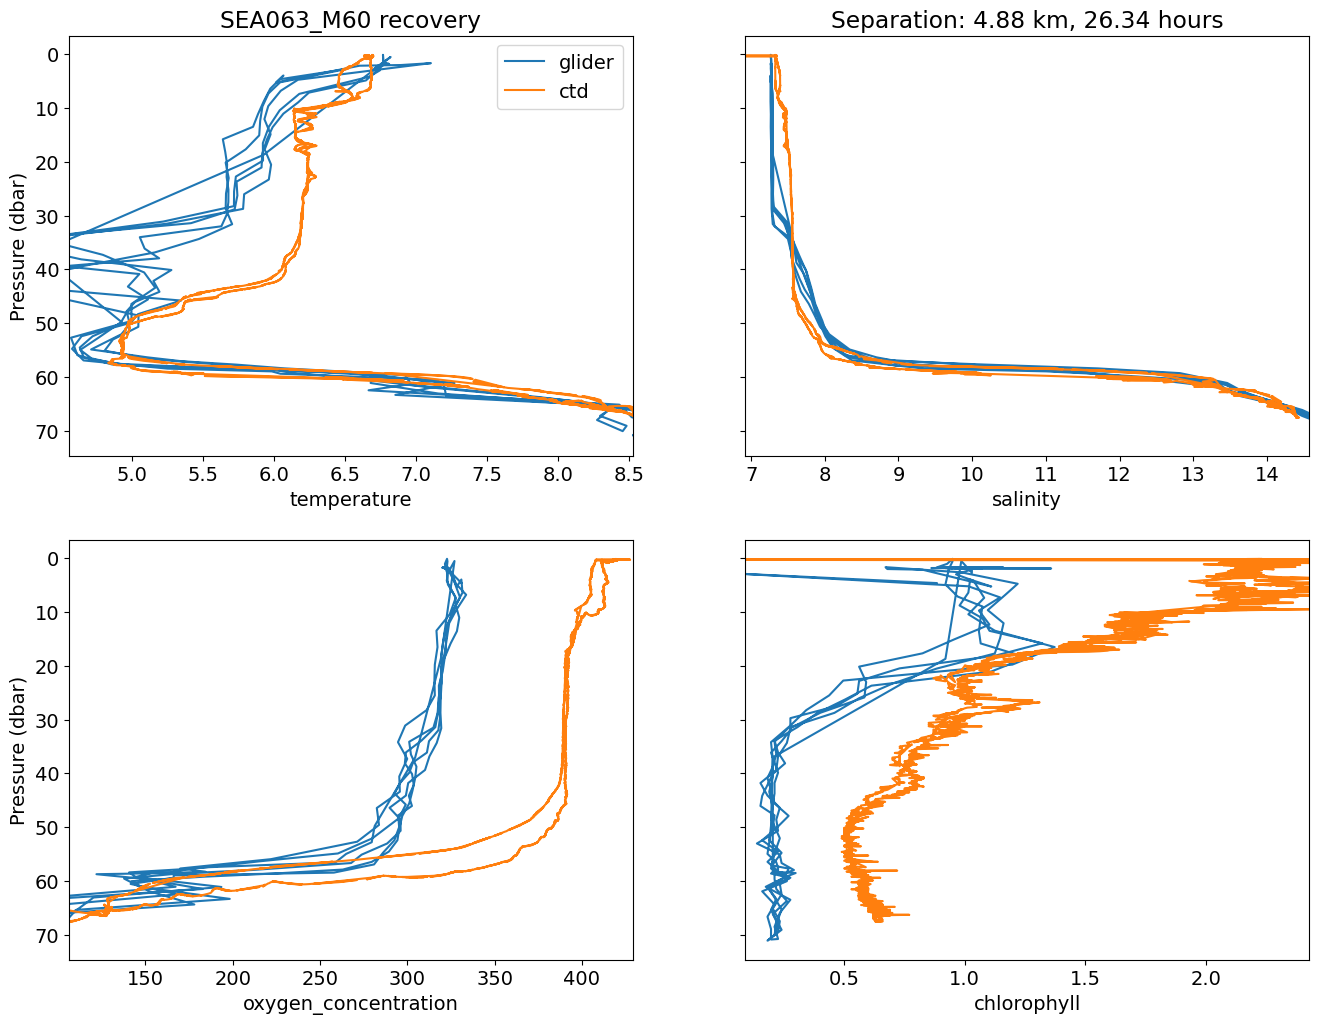

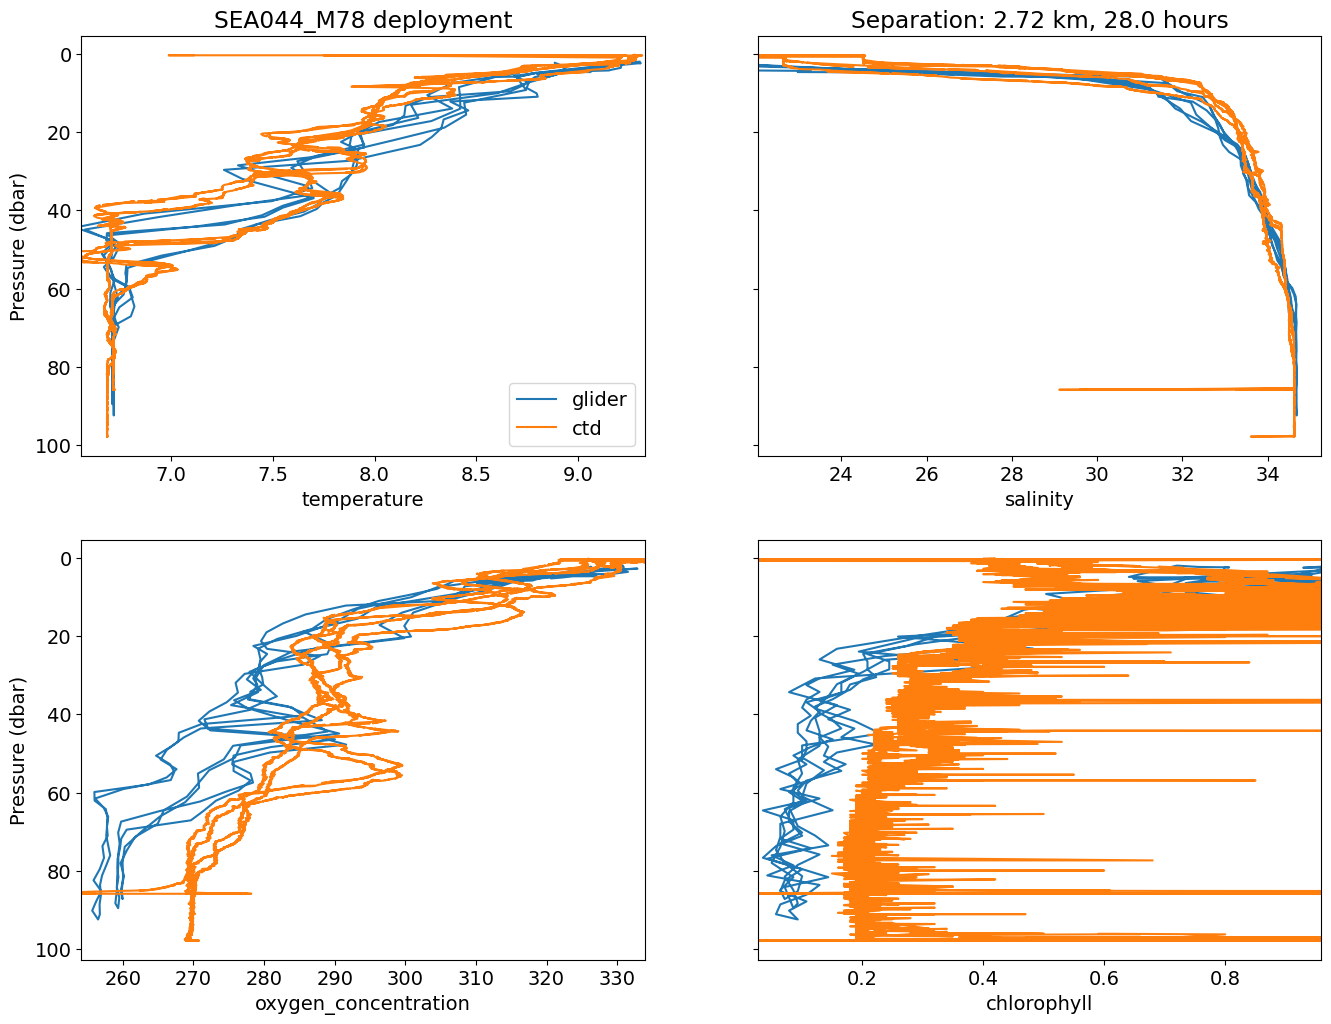

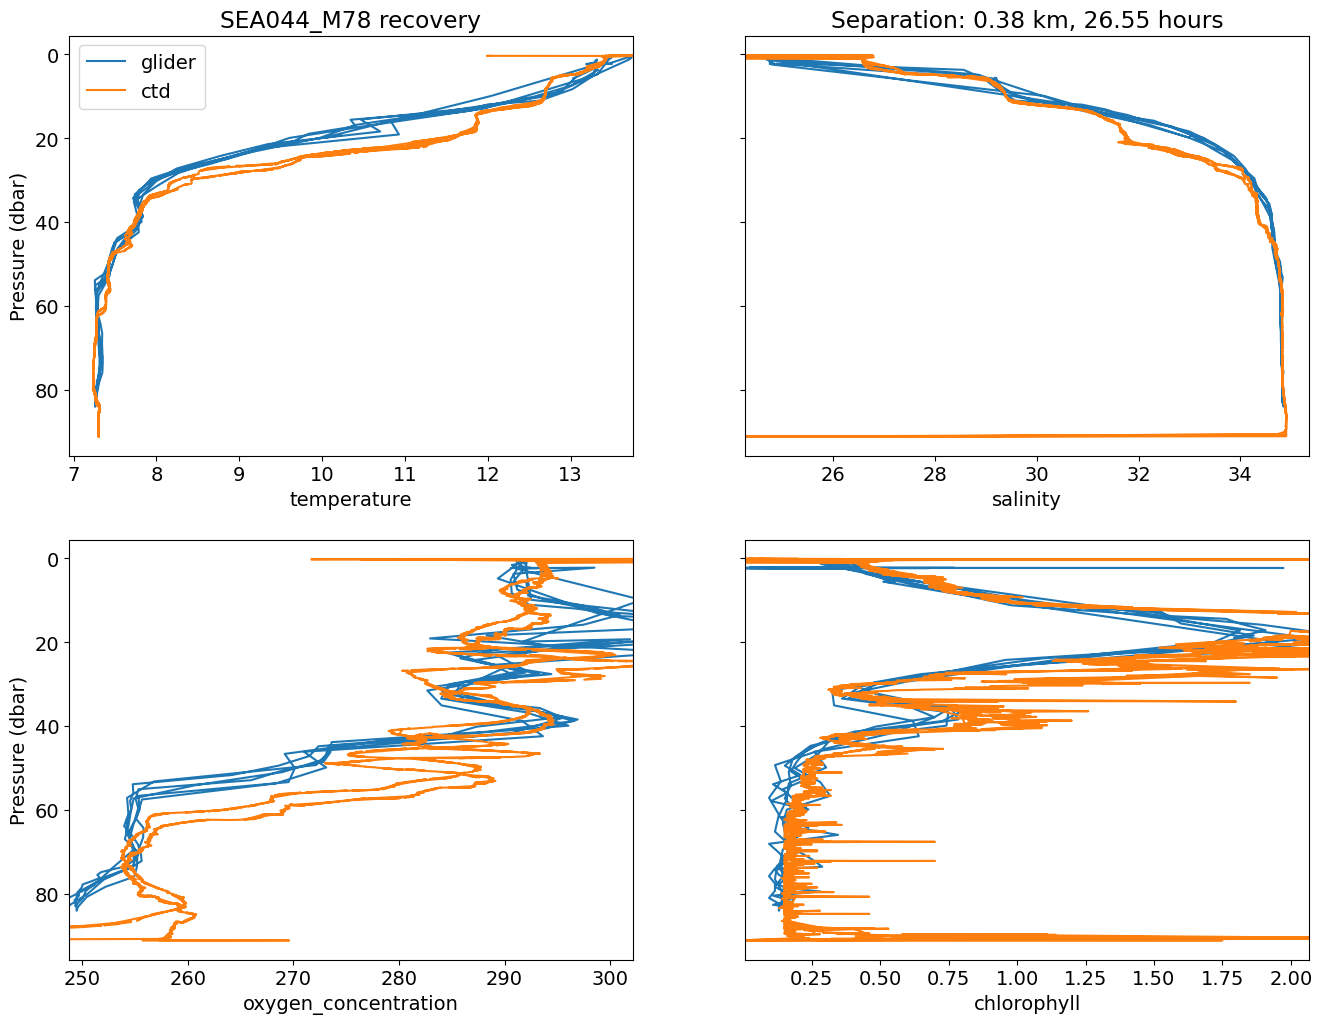

In [6]:
for mission, ds in nrt_dict.items():
    ctds = utils.nearby_ctd(ds, comparison_plots=True)
    found = list(ctds.keys())
    if found == ['deployment', 'recovery']:
        continue
    print(mission[4:], found, ds.attrs["basin"])


# Get nearest argo floats to glidermission

Argo floats are a great utility for checking your data against. In this notebook, we look for argo floats within a set spatio-temporal range of our glider data.

We will use the excellent [argopy](https://github.com/euroargodev/argopy) library, which uses ERDDAP to fetch argo data.


### 1. Download glider datasets from our own ERDDAP


First, we fetch a list of all nrt datasets


In [7]:
datasets_to_download = utils.find_glider_datasets()

Now we download the datasets, specifying only the variables that we will need

In [8]:
# Specify variables of interest
desired_variables = [
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
    "pressure"
]

glider_datasets = utils.download_glider_dataset(datasets_to_download[::10], nrt_only=True,
                                               variables=desired_variables)

  0%|          | 0/18 [00:00<?, ?it/s]

### 2. Find nearest argo profile for each glidermission

We can set tolerances for how close an argo profile must be in time and space

In [9]:
def nearest_argo_profile(ds_glider, lat_window=0.5, lon_window=1, time_window = np.timedelta64(7, "D")):
    """
    Finds the nearest argo profile to a supplied glidermission. Uses ifremer ERDDAP
    """
    mean_lon = ds_glider.longitude.mean().values
    mean_lat = ds_glider.latitude.mean().values
    mean_time = ds_glider.time.mean().values
    max_pressure = ds_glider.pressure.max()
    min_time = str(mean_time-time_window)[:10]
    max_time = str(mean_time+time_window)[:10]
    if not max_pressure:
        print("bad pressures")
        return None
    search_region = [mean_lon-lon_window, mean_lon+lon_window, 
                 mean_lat-lat_window, mean_lat+lat_window,
                 0, int(max_pressure),
                 min_time, max_time]
    try:
        ds = ArgoDataFetcher(src='erddap').region(search_region).to_xarray()
        ds2 = ds.argo.point2profile()
        closest_time_index = np.abs(ds2.TIME.values-mean_time).argmin()
        profile = ds2.isel({"N_PROF":closest_time_index})
        deg_n = profile.LATITUDE.values - np.nanmean(ds_glider.latitude)
        deg_e = profile.LONGITUDE.values - np.nanmean(ds_glider.longitude)
        ns_ahead = profile.TIME.values - ds_glider.time.mean()
        east_diff, north_diff, time_diff = utils.format_difference(deg_e, deg_n, ns_ahead)
        loc_str = f"Nearest float is {east_diff}, {north_diff} & {time_diff} than mean of glider data"
        print(loc_str)
        return profile
    except:
        print("No floats found within tolerances")
        return None
    

In [10]:
def nearest_argo_profile(ds_glider, lat_window=0.5, lon_window=1, time_window = np.timedelta64(7, "D")):
    """
    Finds the nearest argo profile to a supplied glidermission. Uses ifremer ERDDAP
    """
    mean_lon = ds_glider.longitude.mean().values
    mean_lat = ds_glider.latitude.mean().values
    mean_time = ds_glider.time.mean().values
    max_pressure = ds_glider.pressure.max()
    min_time = str(mean_time-time_window)[:10]
    max_time = str(mean_time+time_window)[:10]
    search_region = [mean_lon-lon_window, mean_lon+lon_window, 
                 mean_lat-lat_window, mean_lat+lat_window,
                 0, int(max_pressure),
                 min_time, max_time]
    try:
        ds = ArgoDataFetcher(src='erddap').region(search_region).to_xarray()
    except FileNotFoundError:
        print("no argo floats in region")
        return None
    ds2 = ds.argo.point2profile()
    closest_time_index = np.abs(ds2.TIME.values-mean_time).argmin()
    profile = ds2.isel({"N_PROF":closest_time_index})
    deg_n = profile.LATITUDE.values - np.nanmean(ds_glider.latitude)
    deg_e = profile.LONGITUDE.values - np.nanmean(ds_glider.longitude)
    ns_ahead = profile.TIME.values - ds_glider.time.mean()
    east_diff, north_diff, time_diff = utils.format_difference(deg_e, deg_n, ns_ahead)
    loc_str = f"Nearest float is {east_diff}, {north_diff} & {time_diff} than mean of glider data"
    print(loc_str)
    return profile


In [11]:
argo_datasets = {}
for name, ds in glider_datasets.items():
    print(f"Trying dataset {name}")
    argo_datasets[name] = utils.nearest_argo_profile(ds, lat_window=1, lon_window=2)
fail, success = 0, 0
for val in argo_datasets.values():
    if val:
        success+=1
    else:
        fail+=1
print(f"\nsuccess: {success}, fail: {fail}")  

Trying dataset nrt_SEA068_M27
Nearest float is 9.8 km E, 109.1 km S & 11.0 hours later than mean of glider data
Trying dataset nrt_SEA069_M13
no argo floats in region
Trying dataset nrt_SEA055_M21
no argo floats in region
Trying dataset nrt_SEA055_M41
no argo floats in region
Trying dataset nrt_SEA057_M75
Nearest float is 198.1 km E, 49.6 km S & 9.8 hours later than mean of glider data
Trying dataset nrt_SEA045_M50
no argo floats in region
Trying dataset nrt_SEA045_M69
Nearest float is 15.3 km W, 11.8 km N & 8.0 hours later than mean of glider data
Trying dataset nrt_SEA063_M21
Nearest float is 17.6 km W, 11.8 km S & 17.8 hours later than mean of glider data
Trying dataset nrt_SEA063_M60
Nearest float is 127.6 km E, 10.2 km S & 9.0 hours earlier than mean of glider data
Trying dataset nrt_SEA079_M16
no argo floats in region
Trying dataset nrt_SEA044_M46
no argo floats in region
Trying dataset nrt_SEA044_M85
no argo floats in region
Trying dataset nrt_SEA067_M41
Nearest float is 46.1 km

### 3. Create scatter plots to compare the temperature and salinity of the glider and its nearest float

We can sanity check our data by visual inspection. A more reliable test would be some form of statistical comparison of the two datasets.

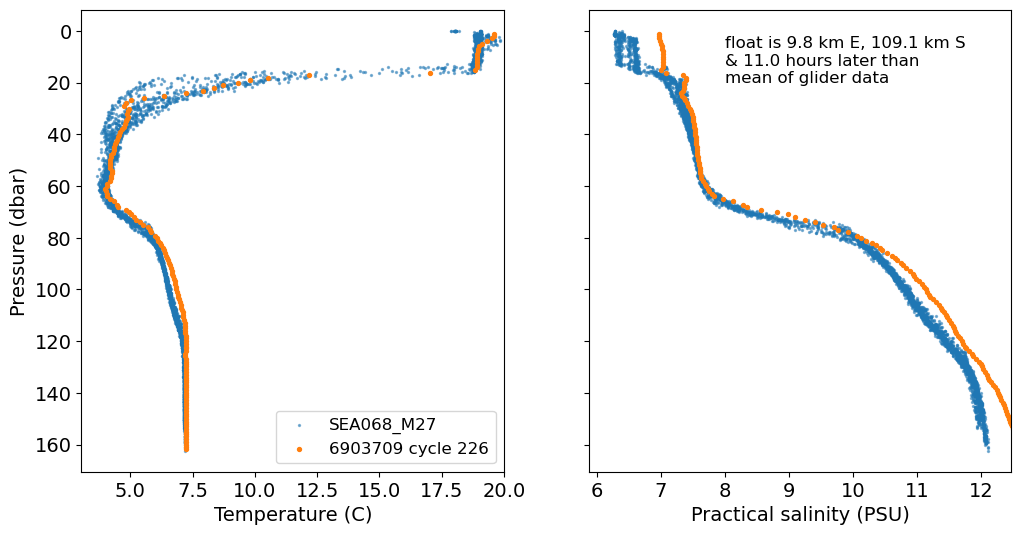

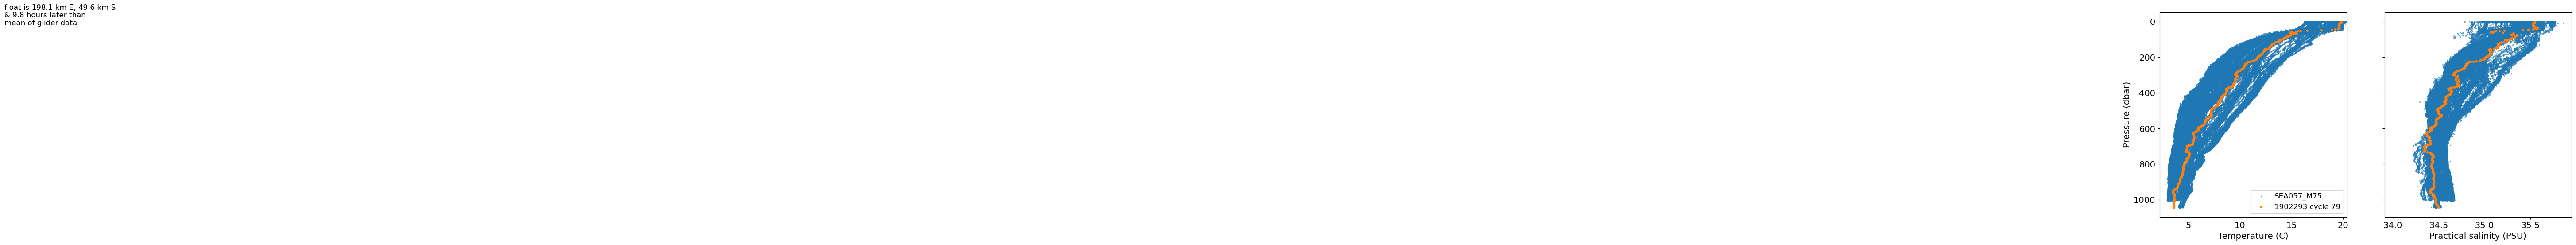

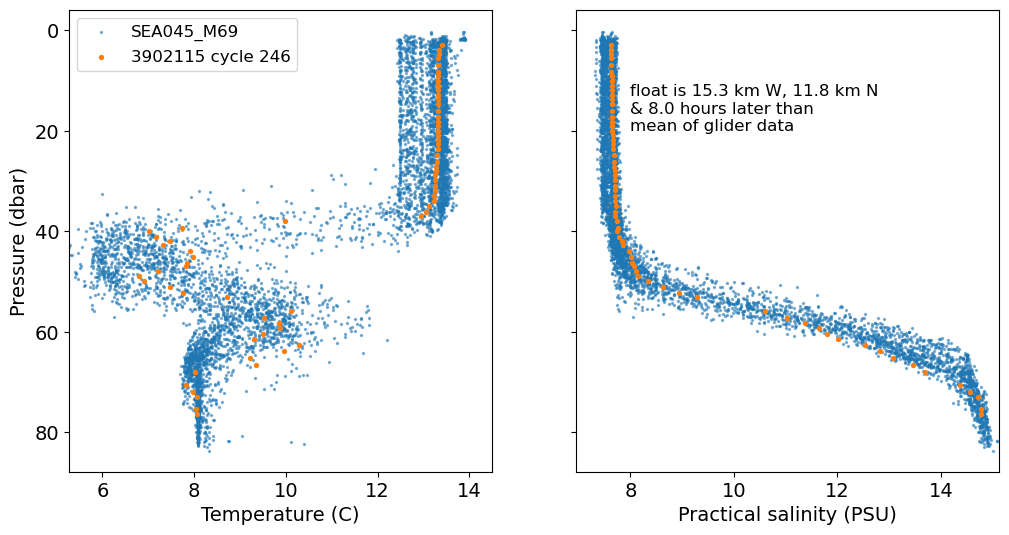

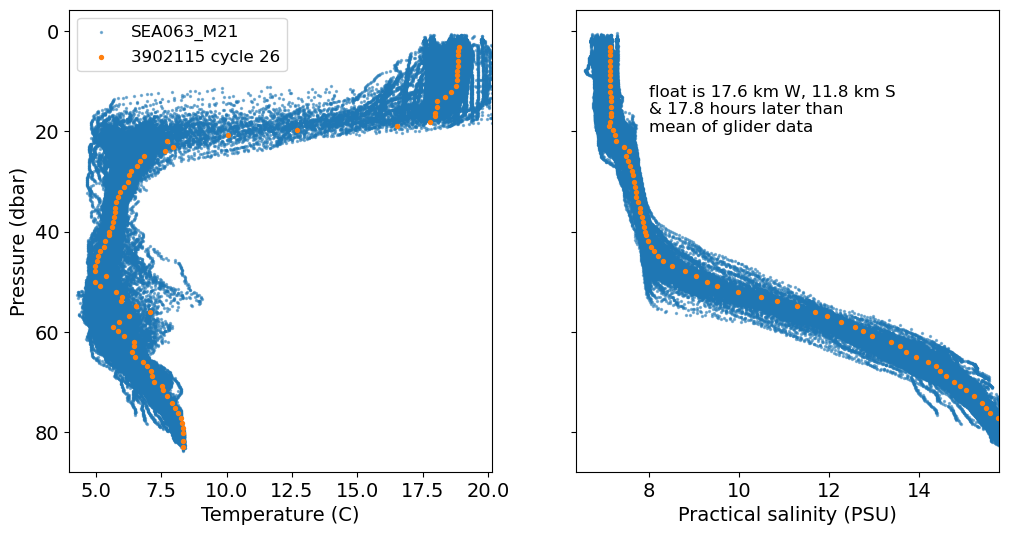

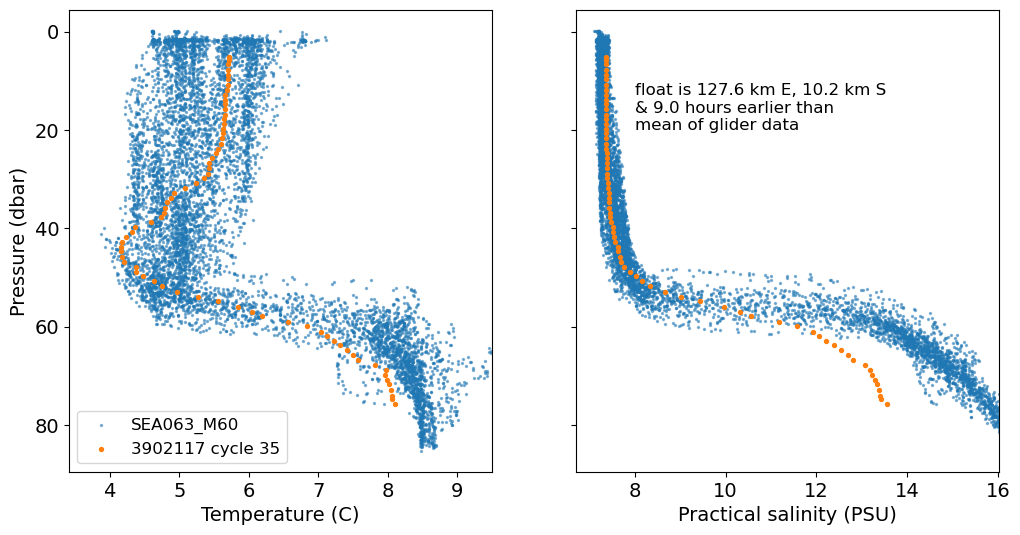

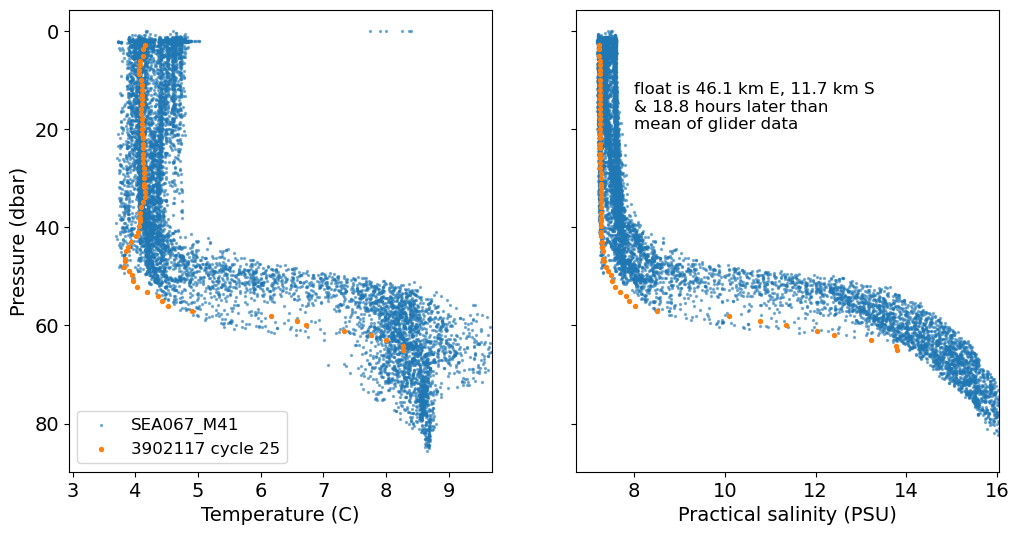

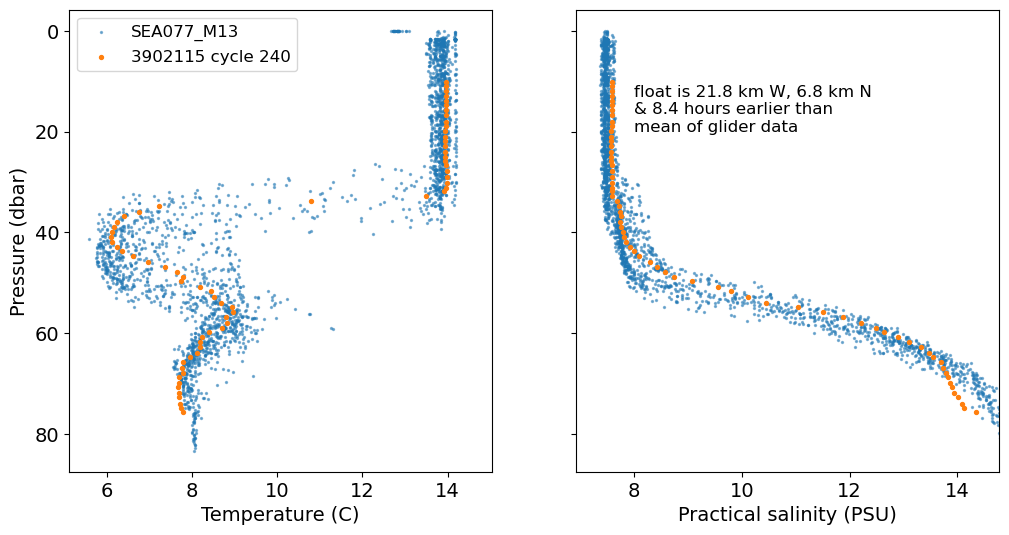

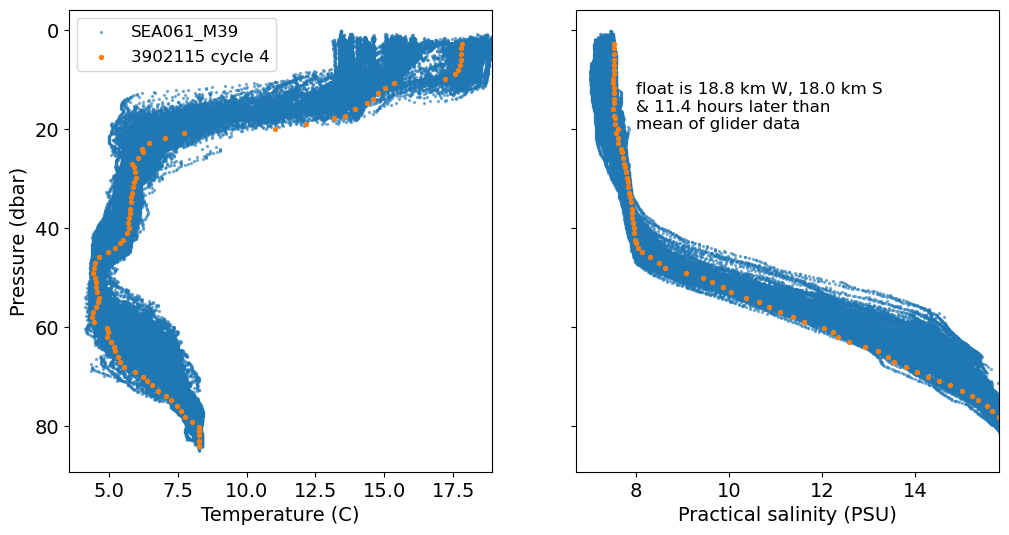

In [12]:
if not Path("figures").exists():
    Path("figures").mkdir()
def compare_scatter(name, ds_glider, ds_argo):
    """
    Create scatter plots of temperature and salinity to visually compare glider and argo float data
    """
    fig, ax = plt.subplots(1,2, sharey="row", figsize=(12, 6))
    ax = ax.ravel()
    argo_name = f"{int(ds_argo.PLATFORM_NUMBER)} cycle {int(ds_argo.CYCLE_NUMBER)}"
    temp_lim = [np.nanpercentile(ds_glider.temperature,5)-1, np.nanpercentile(ds_glider.temperature,95)+1]
    ax[0].scatter(ds_glider.temperature, ds_glider.pressure, s=2, label=name[4:], alpha=0.5)
    ax[0].scatter(ds_argo.TEMP, ds_argo.PRES, s=8, label=argo_name)
    ax[0].invert_yaxis()
    ax[0].set(ylabel="Pressure (dbar)", xlabel="Temperature (C)", xlim=temp_lim)
    sal_lim = [np.nanpercentile(ds_glider.salinity,5)-0.5, np.nanpercentile(ds_glider.salinity,95)+0.5]
    ax[1].scatter(ds_glider.salinity, ds_glider.pressure, s=2, alpha=0.5)
    ax[1].scatter(ds_argo.PSAL, ds_argo.PRES, s=8)
    ax[1].set(xlabel="Practical salinity (PSU)", xlim=sal_lim)
    ax[0].legend(fontsize=12)
    
    deg_n = ds_argo.LATITUDE.values - np.nanmean(ds_glider.latitude)
    deg_e = ds_argo.LONGITUDE.values - np.nanmean(ds_glider.longitude)
    ns_ahead = ds_argo.TIME.values - ds_glider.time.mean()
    east_diff, north_diff, time_diff = utils.format_difference(deg_e, deg_n, ns_ahead)
    loc_str = f"float is {east_diff}, {north_diff}\n& {time_diff} than \nmean of glider data"
    loc_str
    ax[1].text(8, 20, loc_str, fontsize=12)
    
    plt.savefig(f"figures/argo_{name}.png")
    #plt.close("all")

for name, ds_argo in argo_datasets.items():
    if ds_argo:
        compare_scatter(name, glider_datasets[name], ds_argo)

# Create map showing Argo float match locations

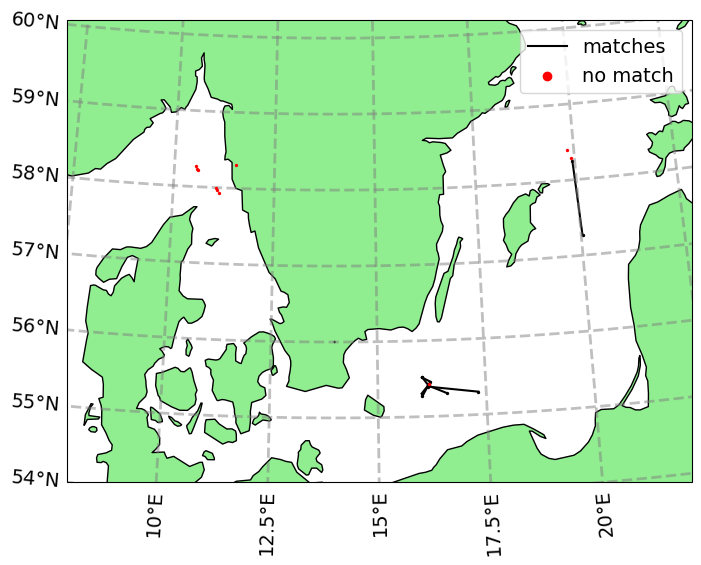

In [13]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=14, central_latitude=56)
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)
ax.set_extent([8, 22, 54, 60], crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                              scale='50m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None

for name, ds_argo in argo_datasets.items():
    ds_glider = glider_datasets[name]
    if ds_argo:
        lon = [ds_argo.LONGITUDE, np.nanmean(ds_glider.longitude)]
        lat = [ds_argo.LATITUDE, np.nanmean(ds_glider.latitude)]
        ax.scatter(lon, lat, transform=pc, s=2, color="k")
        ax.plot(lon, lat, transform=pc, color="k")
    else:
        ax.scatter(np.nanmean(ds_glider.longitude), np.nanmean(ds_glider.latitude),
                   transform=pc, s=2, color="red", zorder=5)

ax.plot((0,1), (0,1),color="k", label="matches")
ax.scatter((0,1), (0,1),color="red", label="no match")

ax.legend()
fig.savefig(f"figures/argo_map.png")


----------------------------

### References

argopy https://argopy.readthedocs.io/en/latest/

ifremer argo ERDDAP server https://erddap.ifremer.fr/erddap/index.html